# Module 2: Factor Models

In this module, we will explore linear factor models (LFMs). 

## Table of Contents:
&nbsp;&nbsp;0. [Motivation of Factor Models](#0)

&nbsp;&nbsp;1. [Introduction to Linear Factor Models](#1)


&nbsp;&nbsp;2. [Factor Model in Asset Return Interpretation](#2)   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.0 [Model Setup](#2.0)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Plotting and Exploring the data](#2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 [OLS Results](#2.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 [OLS Drawbacks](#2.3)


&nbsp;&nbsp;3. [Alternative ML Methods](#3)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.0 [LASSO Regression](#3.0)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.0 [Best Subset Regression](#3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [LASSO with cross validation](#3.2)


&nbsp;&nbsp;4. [Relaxing the time period assumption, Regime Analysis](#4)   

&nbsp;&nbsp;5. [Additional Resources](#5)

&nbsp;&nbsp;6. [User Section](#6)

## 0. Motivation of Factor Models <a class="anchor" id="0"></a>

Factors models are widely used in industry and serve two main purposes.

The first is to reduce the complexity of modeling asset price movements.  For instance, trying to build a model that completely explains stock price movements is near impossible.  In order to build a model for your favorite stock one would need to model supply, demand, sentiment, current and expected future earnings of the stock, news, interest rates, risk premia...

It's near impossible to calibrate such a complicated model!  Instead, factor investors assume that there are N important factors that drive a portion of the asset returns.  They then say that at the portfolio level, asset specific movements can be averaged out, and only those N variables remain.  So to understand what drives the portfolio returns we only need to model the effect of that small number of factors.

Alternativly, understanding the factor loadings of the individual assets allows us to estimate the covariance of our returns.  We state without proof that if one understands the factor loadings and the covariance of the factor returns, one can then compute an estimate for the covariance of the assets themselves.

Finally factor models can also be used for hedging.  We again state without proof that the factor loadings represent the hedging ratio one would use to minimize the volatility of your portfolio.

In this module we will walk though multiple ways of estimating factor loadings, and discuss their relative strenghts and weaknesses.

## 1. Introduction to Linear Factor Models <a class="anchor" id="1"></a>



A linear factor model can be expressed in the following equation

\begin{equation*}
    y_t = {\bf X_t} \beta + \epsilon_t
\end{equation*}

$t$ is used to index each observation. ${\bf y} = \{y_t\}$ is called the dependent variable for observation $t$ and the vector ${\bf X_t} = (X_t^1, X_t^2, \dots, X_t^m)$ is called the set of factors (statisticians would call them independent or explanatory variables) for observation $t$. 

${\bf \beta} = (\beta_1,\dots,\beta_m)'$ are called the factor loadings.

As in most of finance, the dependent variable $y_t$ will the be the returns of some asset, and the independent variables will the the return of the factors.  We call this a linear factor model because we have assumed a linear relationship between the returns of the factors and the returns of the assets.

With historical data, the factor loadings ${\bf \beta}$ can be estimated via Ordinary Least Squares (OLS) estimation:

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {\bf X_t} {\bf \beta})^2 \bigg\}.
\end{equation*}


Let's run the OLS estimation with asset return data and apply extensions to the model.

## 2. Factor Model in Asset Return Interpretation <a class="anchor" id="2"></a>

If $y_t$ represent an asset return at time t, the linear factor model can help us interpret the source of the asset return and attribute it to the factor returns.

In this example, we are interested in explaining the asset returns with a five-factor model:

1) World Equity: This factor represents worldwide equity returns.

2) US Treasury: This factor contains return from treasury bonds in United States, the bonds with the least risk.

3) Bond Risk Premia: This is a credit factor that captures extra yield from risky bonds.  Defined as the spread between high risk bonds and US Treasury bonds.

4) Inflation Protection: This is a "style" factor that considers the difference between real and nominal returns, thus balances the need for both.

5) Currency Protection: This is also a "style" factor that includes risk premium for US domestic assets.


### 2.0 Model Setup <a class="anchor" id="2.0"></a>
For the first step, let's import necessary packages and define our functions (for later use):


In [1]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import importlib as imp

import FactorModelLib as fm #the code that wraps around the sikitlearn implementations
import error_analysis as er #runs error analysis
import config
import importlib as imp

import cvxpy as cp
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Next, read our data and check the assets/factors we have:

In [2]:
all_data = pd.read_csv(config.dataPath)
all_data.head()
all_data[config.dateName] = pd.to_datetime(all_data[config.dateName])

### 2.1 Plotting and Exploring the data <a class="anchor" id="2.1"></a>

First things first, let's look at the data.

In [3]:
all_data.head(5)

,Date,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,Regime-5,Regime-7,US Equities,Real Estate,Commodities,Corp Bonds
0,1985-01-01,0.028511,0.031500,0.006408,-0.016265,0.030292,1,1,0.081301,0.056605,0.021351,0.048963
1,1985-02-01,-0.009204,-0.044692,0.057381,0.006362,0.010258,1,1,0.030075,0.016448,-0.015217,-0.042029
2,1985-03-01,0.075134,0.028719,-0.024396,-0.002848,-0.020739,1,1,-0.007299,-0.006716,0.037171,0.032666
3,1985-04-01,-0.002459,0.023084,-0.004869,0.003089,0.008187,1,1,-0.012255,0.000906,-0.035116,0.037125
4,1985-05-01,0.040245,0.086780,-0.044417,0.004077,-0.002219,1,1,0.064516,0.027241,0.004351,0.104199


Next, determine the time increment for our data

In [4]:
fm.data_time_periods(all_data, config.dateName)

'monthly'

In [5]:
startDate = all_data[config.dateName].min()
endDate = all_data[config.dateName].max()

Let's get more specific.  Let's plot our data over time

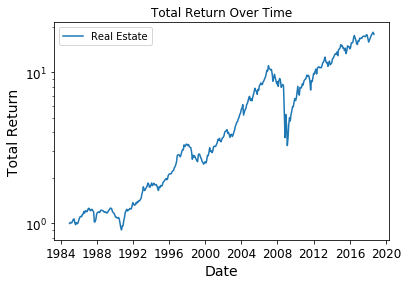

In [6]:
name = 'Real Estate'
fm.plot_returns(all_data, name, flag='Total Return')

As a sanity check, find the months where the monthly return of US equities were the lowest.

In [7]:
all_data.sort_values('US Equities').head(3)

,Date,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,Regime-5,Regime-7,US Equities,Real Estate,Commodities,Corp Bonds
33,1987-10-01,-0.145045,0.068928,-0.101626,-0.010618,-0.025647,-1,-1,-0.227451,-0.142819,-0.013019,0.047145
285,2008-10-01,-0.204945,-0.039976,-0.112578,-0.083037,0.024725,-1,-1,-0.173147,-0.312202,-0.295256,-0.068198
286,2008-11-01,-0.111894,0.154699,-0.249246,-0.044064,-0.010747,-1,-1,-0.162932,-0.337308,-0.175630,0.053776


October 1987 was [black monday](https://en.wikipedia.org/wiki/Black_Monday_(1987)) and October / November 2008 was the beginnings of the [financial crisis](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008)

### 2.2 OLS Regression <a class="anchor" id="2.2"></a>

Now let's return to factor models.  Building a factor module is equivalent to solving for the factor loadings defined in part 1.  Ordinary Least Squares (OLS) regression is the simplest way.

As we mentioned in part 1, OLS regression is equivalent to solving the following optimization problem

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - {\bf X_t} {\bf \beta})^2 \bigg\}.
\end{equation*}

It actually has a closed form solution.

\begin{equation*} 
    \hat{\beta}^{\text{OLS}} = ({\bf X_t}^\intercal {\bf X_t})^{-1} {\bf X_t}^\intercal{\bf Y_t}
\end{equation*}

Where ${\bf Y_t}$ is the vector representation of $y_t$

Let's take a second to look at, $\hat{\beta}$, the factor loadings.  What do they mean?  They represent the effect on the dependent variable caused by movement in the underlying factor.

In this course we will be using the sikitlearn package to build models.  But since we have a closed form solution, let's check that the closed form solution gives the same answer as sikit-learn.

In [8]:
# Linear Regression (OLS)
Factors = all_data[config.factorName].values
Assets = all_data[config.assetName].values

Asset_RE = Assets[:,1]
Factors_ones = np.concatenate((np.ones((all_data.shape[0],1)),Factors),axis=1)
theory_beta = np.linalg.inv(Factors_ones.T.dot(Factors_ones)).dot(Factors_ones.T).dot(Asset_RE)
print('Dependent variable is Real Estate')
print('Historical Timeperiods ' +  fm.num_to_month(startDate.month) +  " " + str(startDate.year)
      + fm.num_to_month(endDate.month) +  " " + str(endDate.year))
opt = dict()
opt['nameOfReg'] = 'theory_beta'
fm.display_factor_loadings(theory_beta[0], theory_beta[1:], config.factorName, opt)

Dependent variable is Real Estate
Historical Timeperiods January 1985September 2018
             Intercept  World Equities  US Treasuries  Bond Risk Premium  \
theory_beta  -0.003587        0.310261       1.212508           1.054238   

             Inflation Protection  Currency Protection  
theory_beta              0.287919              0.36184  


In [9]:
#Linear Regression via Scikit-learn
options = fm.create_options()
options['nameOfReg'] = 'sikit-learn OLS'
fm.linear_regression(all_data, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                 Intercept  World Equities  US Treasuries  Bond Risk Premium  \
sikit-learn OLS  -0.003587        0.310261       1.212508           1.054238   

                 Inflation Protection  Currency Protection  
sikit-learn OLS              0.287919              0.36184  


Indeed it does

### 2.3 OLS Drawbacks <a class="anchor" id="2.3"></a>

OLS has major drawbacks.  First, OLS has no mechanism to filter out noise variables.  Second, it assumes that factor loadings are constant over time. In practice, you will generally have many variables that you would like to filter down.  Moreover, the assumption that the factor loadings are constant over time is restrictive, and not true.  In fact, we will show that factor loadings are highly dependent on the time period.

In this section we give example of the two drawbacks.  In section 3, we will introduce ways of filtering noise variables.

To demonstrate how OLS can be susceptible to noise, we introduce a noise variable positivly correlated with the World Equities factor.  Then we re-run the OLS regression. The OLS regression chosses to average the two signals, changing the loading on the World Equity factor.

In [10]:
#Calculate a noise variable
std = all_data['World Equities'].std()*(2)
nPeriods = all_data.shape[0]
noise = np.random.normal(loc=0, size=(nPeriods))
noise = np.reshape(std*noise + np.array(all_data['World Equities']), (nPeriods,1))
all_data['Noise'] = noise
factorNameWithNoise = config.factorName + ['Noise']

In [11]:
options = fm.create_options()

In [12]:
fm.linear_regression(all_data, 'Real Estate', factorNameWithNoise, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
         Intercept  World Equities  US Treasuries  Bond Risk Premium  \
No Name  -0.003899        0.338229       1.215966           1.053312   

         Inflation Protection  Currency Protection     Noise  
No Name              0.272547             0.367583 -0.023069  


Notice that the sum of World Equities Beta + Noise Beta is around .31.  Feel free to re-run the previous 2 code blocks.  It will generate a new noise term, and notice that each time the noise term will then effects the World Equities loading.  That noise term is directly causing estimation error in the true loading (Beta value) of the World Equity factor.

To demonstrate the second drawback we will show that the OLS estimator depends greatly on the time period.  First, we will pick different time periods and run the OLS regression.  We'll show that the factor loadings can change dramatically depending on the time period.  To formalize this idea, we will filter our data into two different regimes.  The first regime "normal", will be months where US Equities had a positive monthly return.  The second, "crash" will be months where US Equities had a negative return.  These are crude approximations, but even with this crude definition we will return substantially different factor loadings.

In a future module we will refine our definition of crash periods using LASSO.

To review, here are the factor loadings using the full data set

In [13]:
options['nameOfReg'] = 'OLS full data'
fm.linear_regression(all_data, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
               Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS full data  -0.003587        0.310261       1.212508           1.054238   

               Inflation Protection  Currency Protection  
OLS full data              0.287919              0.36184  


For a first example, let's just pick a "random" (hint, it's not random) time period where we might see different factor loadings.  One could imagine that maybe during crash periods the factor loadings would change.  So let's pick the financial crisis years as our period to investigate.

In [14]:
normalData = all_data[all_data['US Equities'] > 0].copy()
options['nameOfReg'] = 'OLS Normal'
fm.linear_regression(normalData, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
            Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS Normal    0.00348         0.15022        1.30286           1.100558   

            Inflation Protection  Currency Protection  
OLS Normal              0.210193              0.05183  


Next we perform the analysis on crash months

In [15]:
crashData = all_data[all_data['US Equities'] <= 0].copy()
options['nameOfReg'] = 'OLS Crash'
fm.linear_regression(crashData, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between March 1985 to June 2018 inclusive   
           Intercept  World Equities  US Treasuries  Bond Risk Premium  \
OLS Crash  -0.011274        0.365824       0.959781           0.792532   

           Inflation Protection  Currency Protection  
OLS Crash              0.540801             0.588727  


Even with a crude definition of a "crash" regime we have isolated different factor loadings.  Notice that during normal periods the loading on Currency Protection is close to zero, but during crash periods is 10x larger!

## 3 Alternative ML Methods <a class="anchor" id="3"></a>

Now that we have motivated the drawbacks of OLS, we can move to modern machine learning techniques.  We will discus two new methods in this section as improvements to OLS to handle noise variables.

The first, LASSO regression, is the simplest version of regularized regression.  Regularized regression means that we add a penalty term to the optimization problem to penalize the model's complexity.  For the sake of intuition, imagine if we could penalize the number of non zero coeficients we add to the model.  In that instance we would expect that the model would only consider the variables that really influence Y, and ignore the noise variables.  LASSO regression (defined below) does exactly that.

The second method is called "best subset selection."  Conceptually, the optimization problem is directly constrained to only allow for a certain number of non zero coeficients.  Put another way, best x-subset regression says "I want the best model where I can at maximum use x variables."

### 3.0 LASSO Regression <a class="anchor" id="3.0"></a>

We define LASSO regression as the following optimization problem.

\begin{equation*} 
    {\hat{\beta}}^{\text{LASSO}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t \beta)^2 + \lambda \sum_{j=1}^{m}|\beta_j| \bigg\}.
\end{equation*}

Note that it is the same as the OLS regression, but with a second penalty term.  As stated above, it directly penalizes the use of non zero coeficients and can be shown to set factor loadings to zero.  If you want to learn more about the theoretical properties of LASSO regression.  The text book [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) covers the method in detail.

$\lambda$ is called a hyperparameter which you need to choose.  Sikit-learn doesn't use $\lambda$ it uses $\alpha$ which can be related via the following equation

\begin{equation*}
    {\frac{\lambda}{2*n} = \alpha}
\end{equation*}

Where $n$ is the number of data points.  For now, let's arbitrarily pick $\lambda = .1$

In [16]:
LASSO_test = Lasso(alpha=0.1/(2*all_data.shape[0]), fit_intercept=True)
LASSO_test.fit(all_data[config.factorName],all_data['Real Estate'])
print('Dependent variable is Real Estate')
print('Historical Timeperiods ' +  fm.num_to_month(startDate.month) +  " " + str(startDate.year) + " " +
      fm.num_to_month(endDate.month) +  " " + str(endDate.year))
opt = dict()
opt['nameOfReg'] = 'LASSO OLS'
fm.display_factor_loadings(LASSO_test.intercept_, LASSO_test.coef_, config.factorName, opt)

Dependent variable is Real Estate
Historical Timeperiods January 1985 September 2018
           Intercept  World Equities  US Treasuries  Bond Risk Premium  \
LASSO OLS   0.001834        0.349738         0.5422           0.574002   

           Inflation Protection  Currency Protection  
LASSO OLS                   0.0                  0.0  


Notice that LASSO sets factor loadings to zero.  Because of this, it can filter out noise variables.  Let's rerun the analysis including the noise variable.

In [17]:
LASSO_with_noise = Lasso(alpha=.1/(2*all_data.shape[0]), fit_intercept=True)
LASSO_with_noise.fit(all_data[factorNameWithNoise], all_data['Real Estate'])
factorNames = config.factorName + ['Noise']
print('Dependent variable is Real Estate')
print('Historical Timeperiods ' +  fm.num_to_month(startDate.month) +  " " + str(startDate.year) + " " + 
      fm.num_to_month(endDate.month) +  " " + str(endDate.year))
opt['nameOfReg'] = 'LASSO With Noise'
fm.display_factor_loadings(LASSO_with_noise.intercept_, LASSO_with_noise.coef_,factorNames, opt)

Dependent variable is Real Estate
Historical Timeperiods January 1985 September 2018
                  Intercept  World Equities  US Treasuries  Bond Risk Premium  \
LASSO With Noise   0.001834        0.349738       0.542199           0.574001   

                  Inflation Protection  Currency Protection  Noise  
LASSO With Noise                   0.0                  0.0   -0.0  


Depending on seed for the noise variable, the LASSO regression either makes the noise factor loading very small, or sets it to zero.

### 3.1 Cross Validation  <a class="anchor" id="3.1"></a>

The previous section ignored the largest issue in LASSO regression, the choice of $\lambda$.  In practice, most people use cross-validation.  We will not give a formal definition of cross-validation here, and instead we will give a heuristic.

First, break the training set into $k$ folds, and define a list of $\lambda$ values.  For each fold, and for each $\lambda$, train the model $k-1$ other folds, and calculate the error on the test fold.  At the end of this, you will have $k$ out of sample errors for each value of lambda.  Then pick the $\lambda$ which satisfies produces the average error across your out of sample tests.

Here we use cross validation to pick the optimal lambda value for lasso.

In [18]:
options = fm.create_options_cv_lasso()
fm.cross_validated_lasso_regression(all_data, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
best lambda = 0.048634343434343426
         Intercept  World Equities  US Treasuries  Bond Risk Premium  \
No Name  -0.000342        0.311805       0.875641           0.835079   

         Inflation Protection  Currency Protection  
No Name              0.044825                  0.0  


Notice how the cross validated LASSO model gives smaller factor loadings than OLS.

### 3.2 Best Subset Regression <a class="anchor" id="3.2"></a>

Formally, we set can define the best subset regression as follows:
Let $\textbf{z}$ be a vector of binary variables, let $ M $ be a very large number
For simplicity, let $ \text{total_vars} $ be the number of variables considered and $ \text{max_vars} $ be the number max number of variables allowed in the subset

\begin{equation*} 
    {\hat{\beta}}^{\text{Best Subset}} = argmin_{\beta}\bigg\{\sum_{t=1}^{n} (y_t - X_t \beta)^2 \bigg\}.
\end{equation*}

\begin{equation*} 
    \sum_{i=1}^{\text{max_vars}} z_i \leq \text{max_vars,}  \hspace{2mm} Mz + \beta \geq 0 \text{  and  } \beta \leq Mz \text{  ,  } \textbf{z } \text{ binary}
\end{equation*}

In [19]:
options['maxVars'] = 2
options['nameOfReg'] = 'Best Subset with maxVars = 2'
fm.best_subset_regression(all_data, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 2  -0.001956    2.103416e-09       1.453734   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 2           1.395798         -3.542204e-11   

                              Currency Protection  
Best Subset with maxVars = 2        -2.118101e-10  


Notice how the best subset selection gives the exact same non zero variables as LASSO.

Of course you can vary the number non-zero coeficients...

In [20]:
options['maxVars'] = 3
options['nameOfReg'] = 'Best Subset with maxVars = 3'
fm.best_subset_regression(all_data, 'Real Estate', config.factorName, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 3  -0.002295        0.274697       1.186262   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 3           1.091385          1.223532e-09   

                              Currency Protection  
Best Subset with maxVars = 3         4.284109e-10  


As we claimed before, best subset can also drop out noisy variables like LASSO.  The following code block re-runs the best subset regression with the noise variable.  Notice that like LASSO, it also filters out the noise variable.

In [21]:
options['maxVars'] = 2
options['nameOfReg'] = 'Best Subset with maxVars = 2'
fm.best_subset_regression(all_data, 'Real Estate', factorNameWithNoise, options)

Dependent Variable is Real Estate
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 2  -0.001956    4.416619e-10       1.453721   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 2           1.395788         -1.593033e-11   

                              Currency Protection         Noise  
Best Subset with maxVars = 2        -4.185457e-11  1.135471e-09  


One might ask, why don't we always use best subset selection?  After all, it seems the most direct way to pick the best n variable model.  Well, one reason is because it's a mixed integer linear program.  The constraint on $\textbf{z}$ makes the system hard to solve for large numbers of variables.  Although some recent work has been done to make the optimization problem feasible using hundres of variables, LASSO (and other methods) works for potentially thousands of factors.

## 4 Relaxing the time period assumption, Regime Analysis <a class="anchor" id="4"></a>

We haven't discussed how to address the second drawback of factor analysis, namely that over different time periods the factor loadings can change.

In the next section we will show how to define regimes using modern machine learning techniques.  We will then use the techniques covered in this module to estimate the factor loadings for each regime.

## 5 Additional Resources <a class="anchor" id="5"></a>

For more information on Lasso Regression, one can refer to [wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics)) or the original paper [here](http://statweb.stanford.edu/~tibs/lasso.html)

If you want to learn more about best subset verses LASSO verses and other variable selection techniques, we encourage you to skim through [this paper](http://www.stat.cmu.edu/~ryantibs/papers/bestsubset.pdf)

## 6 User Section <a class="anchor" id="5"></a>
In this section, we provide a space for the user to run their own analysis.

Instructions:
   * Go to the file config.py and turn the demo variable to False
   * Change the following variables
      * dataPathUser: path to data you wish to analyse, must be in CSV format
      * factorNameUser: Make a list of the factors you wish to consider.  The elements of this list must be columns in the csv file located at dataPathUser
      * assetNameUser: string, names the asset you wish to calculate factor loadings with
      * dateNameUser: defines the date column in your data set
      
This section runs OLS, LASSO, and Best Subset Regression.  Feel free to compare and contrast any results you get in this section to the results from the above notebook

In [22]:
imp.reload(config)
if(config.isDemo == False):
    #Load in Data
    dataUser = pd.read_csv(config.dataPathUser)
    dataUser[config.dateNameUser] = pd.to_datetime(dataUser[config.dateNameUser])

### OLS Loading

In [23]:
imp.reload(fm)
if(config.isDemo==False):
    optionsUser = fm.create_options()
    optionsUser['printLoadings'] = True
    optionsUser['nameOfReg'] = 'OLS for ' + str(config.assetNameUser)
    fm.linear_regression(dataUser, config.assetNameUser, config.factorNameUser, optionsUser)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                     Intercept  World Equities  US Treasuries  \
OLS for US Equities   0.000049        0.536876       0.579876   

                     Bond Risk Premium  Inflation Protection  \
OLS for US Equities            0.61014              0.083233   

                     Currency Protection  
OLS for US Equities             0.625217  


### CV Lasso

In [24]:
if(config.isDemo==False):
    optionsUser = fm.create_options_cv_lasso()
    optionsUser['printLoadings'] = True
    optionsUser['nameOfReg'] = 'CV Lasso for ' + str(config.assetNameUser)
    fm.cross_validated_lasso_regression(dataUser, config.assetNameUser, config.factorNameUser, optionsUser)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
best lambda = 0.015912424242424242
                          Intercept  World Equities  US Treasuries  \
CV Lasso for US Equities   0.001211         0.53405        0.46859   

                          Bond Risk Premium  Inflation Protection  \
CV Lasso for US Equities           0.539369              0.001968   

                          Currency Protection  
CV Lasso for US Equities             0.469029  


### Best Subset Regression

In [25]:
if(config.isDemo==False):
    optionsUser = fm.create_options()
    optionsUser['printLoadings'] = True
    optionsUser['maxVars'] = 2
    optionsUser['nameOfReg'] = 'Best '+ str(optionsUser['maxVars']) + ' Subset Regression for ' + str(config.assetNameUser)
    fm.best_subset_regression(dataUser, config.assetNameUser, config.factorNameUser, optionsUser)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                                          Intercept  World Equities  \
Best 3 Subset Regression for US Equities   0.001766        0.480828   

                                          US Treasuries  Bond Risk Premium  \
Best 3 Subset Regression for US Equities       0.559776           0.631868   

                                          Inflation Protection  \
Best 3 Subset Regression for US Equities          9.721428e-12   

                                          Currency Protection  
Best 3 Subset Regression for US Equities         1.364468e-10  


If you would like to change the number of variables included in the best subset regression.  Change the line
optionsUser['maxVars'] = ... to whatever number of variables you would like to include